# Lab Assignment 2
### 210006819
---
## Part 6: K-Means - DBSCAN Clustering
---



### Mount your Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Installing additional libraries

In [3]:
!pip install lonboard
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.2/884.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.6 MB/s eta 0:00:00


In [4]:
# Import necessary libraries
# I am just following the same order of operations as provided in the Spatial Clustering Initial Guide
import numpy as np
import pandas as pd
import geopandas as gpd
# This is a super popular library for working with ML and DL algorithms.
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import shapely
import folium
import seaborn as sns
import lonboard as lb
from lonboard import Map, ScatterplotLayer
from lonboard import SolidPolygonLayer
from sklearn.cluster import KMeans, DBSCAN

### Task 1 Data Exploration: Load the Chicago parcels dataset using Pandas.


In [5]:
gdf = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/data/Chicago_parcels.shp')

### Task 2: Display the first few rows of the dataset. Investigate the available attributes and their data
types.

In [6]:
gdf.head(10)

,POLY_ID,ID,AREA,PIN_OLD,PIN,geometry
0,1,93,0.01,836300010,836300010,"POLYGON ((1091182.694 1942890.287, 1091173.159..."
1,2,94,0.00,836300011,836300011,"POLYGON ((1092430.298 1943191.955, 1092463.452..."
2,3,96,0.02,836300013,836300013,"POLYGON ((1092323.996 1942962.61, 1092301.306 ..."
3,4,95,0.01,836300012,836300012,"POLYGON ((1092024.119 1942447.762, 1091997.19 ..."
4,5,92,0.01,836300009,836300009,"POLYGON ((1091970.533 1942338.191, 1091929.082..."
5,6,98,0.00,836301007,836301007,"POLYGON ((1091889.266 1942159.981, 1091833.063..."
6,7,97,0.02,836301003,836301003,"POLYGON ((1091753.543 1941824.459, 1091716.52 ..."
7,8,5,0.03,836100006,836100006,"POLYGON ((1092172.233 1942219.598, 1092135.727..."
8,9,7,0.00,836101008,836101008,"POLYGON ((1092423.468 1945012.166, 1092400.259..."
9,10,17,0.01,836101028,836101028,"POLYGON ((1092434.77 1945796.435, 1092773.374 ..."


### T3: Create a map to visualize the spatial distribution of tax parcel polygons in Chicago. This is a dataset with more than a half millions of records, therefore if you use the traditional matplotlib or pandas you will reach the RAM limit of Colab, you need to use lonboard library and the SolidPolygonLayer layer to render polygons.

In [7]:
from lonboard import SolidPolygonLayer
from lonboard import Map
from lonboard import viz


In [8]:
# Now I've changed the CRS I need to reproject the dataframe
gdf_reproj = gdf.to_crs(epsg=4326)

In [9]:
# After reprojecting the data I want to separate the longitude and latitude data because it is currently housed in the column 'geometry' which limits our ability to map
gdf_reproj["latitude"] = gdf_reproj['geometry'].centroid.y
gdf_reproj["longitude"] = gdf_reproj['geometry'].centroid.x
# I defined the geometry back into the GeoDataFrame
geometry = gpd.points_from_xy(gdf_reproj['longitude'], gdf_reproj['latitude'])
gdf_reproj = gpd.GeoDataFrame(data=gdf_reproj, geometry=geometry)

<ipython-input-9-0d45922010b5>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_reproj["latitude"] = gdf_reproj['geometry'].centroid.y
<ipython-input-9-0d45922010b5>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_reproj["longitude"] = gdf_reproj['geometry'].centroid.x


In [10]:
chicago_gdf = gdf_reproj


In [11]:
layer = ScatterplotLayer.from_geopandas(chicago_gdf)
tax_map = Map(layers=[layer],_height=500)
tax_map

Map(custom_attribution='', layers=(ScatterplotLayer(table=arro3.core.Table
-----------
POLY_ID: UInt32
ID: UIn…

### T4 Correlation Analysis: Explore correlations between spatial attributes (latitude, longitude) and numerical attributes. Using the text cell, provide insights into any observed correlations.

In [12]:
print(gdf_reproj.columns)

Index(['POLY_ID', 'ID', 'AREA', 'PIN_OLD', 'PIN', 'geometry', 'latitude',
       'longitude'],
      dtype='object')


From just looking at the columns of the data we can see that the data is primarily numerical. 'POLY_ID' inidcates what number polygon it is in the dataset. 'ID' tells us...
'AREA' is the amount of physical space each tax parcel occupies, of which there will be some variation due to changes in population density and demographic.'PIN_OLD' will just be the outdated version of the tax parcel identification that is now 'PIN'. The 'geometry' data collates both latitude and longitude data

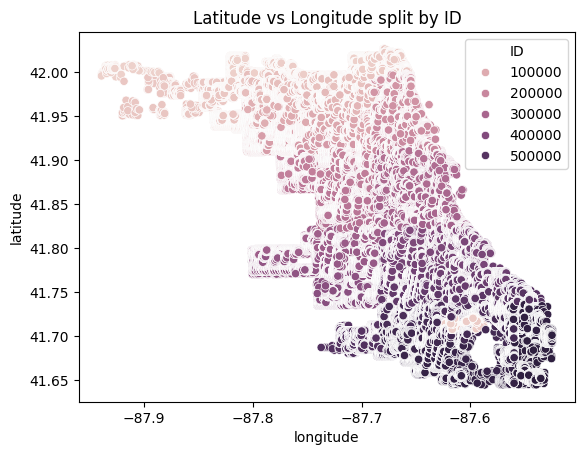

In [13]:
sns.scatterplot(data=gdf_reproj, x="longitude", y="latitude", hue="ID")
plt.title("Latitude vs Longitude split by ID")
plt.show()


This graph just shows the parcel identification system, how they worked acrss the city dividing parcels. We can see that they began numbering the parcels in the north and worked their way south. Therefore, I can posit that there is some correlation between both ID and both latitude and longitude. My hypothesis is that if the tax parcel ID increases that there is a positive correlation with longitude. Alternatively, I would infer that as tax parcel ID increases that there is a negative correlation with latitude. I will test these below.

In [14]:
ID_lat_corr = gdf_reproj["ID"].corr(gdf_reproj["latitude"])
ID_long_corr = gdf_reproj["ID"].corr(gdf_reproj["longitude"])
print(f"Correlation between ID and latitude: {ID_lat_corr}")
print(f"Correlation between ID and longitude: {ID_long_corr}")

Correlation between ID and latitude: -0.9497150632679218
Correlation between ID and longitude: 0.6972254324655941


There is a very strong negative correlation found between latitude and ID. There is also a strong positive correlation between longitude and ID.

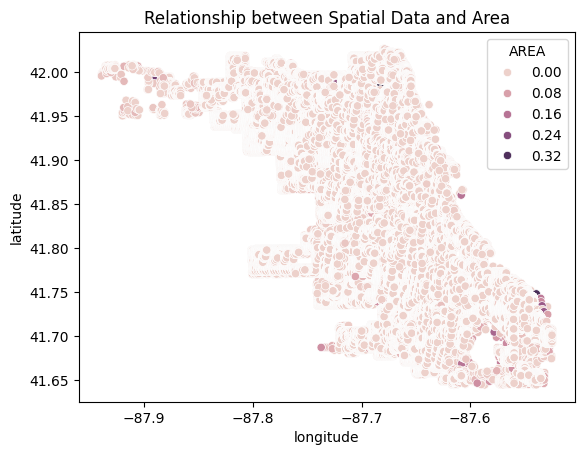

In [15]:
sns.scatterplot(data=gdf_reproj, x="longitude", y="latitude", hue="AREA")
plt.title("Relationship between Spatial Data and Area")
plt.show()

Now I will investigate to see if there are any correlatory relationships between the spatial data and area although it does not look liek there will be any.

In [16]:
AREA_lat_corr = gdf_reproj["AREA"].corr(gdf_reproj["latitude"])
AREA_long_corr = gdf_reproj["AREA"].corr(gdf_reproj["longitude"])
print(f"Correlation between Area and latitude: {AREA_lat_corr}")
print(f"Correlation between Area and longitude: {AREA_long_corr}")

Correlation between Area and latitude: -0.010341752723561932
Correlation between Area and longitude: 0.005169797248550142


As expected, there was very little correlation found between either longitude or latitude for area.

### T5 K-Means Clustering: Implement K-Means clustering with different values of n_clusters.

Task 5 and Task 6 are completed in the same terminal below.


### T6: Visualize the clustering results for each value of n_clusters, using multiple lonboard maps, and customized colour ramps

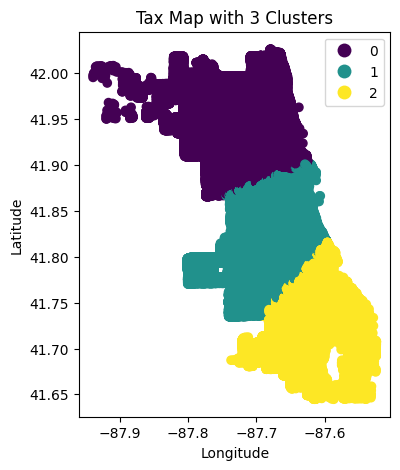

In [17]:
# Implement K-means clustering
# Here I'm using the skitlearn documentation website to write a simple K-means cluster.
kmeans = KMeans(n_clusters=3, random_state=42) #if you figured out what random_state does, try to remove it, to see what happens.
chicago_gdf['kmeans_cluster'] = kmeans.fit_predict(gdf_reproj[["longitude", "latitude"]])

# Visualize K-means clustering result
chicago_gdf.plot(column='kmeans_cluster', categorical=True, legend=True, figsize=(5,5), cmap='viridis')

plt.title('Tax Map with 3 Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


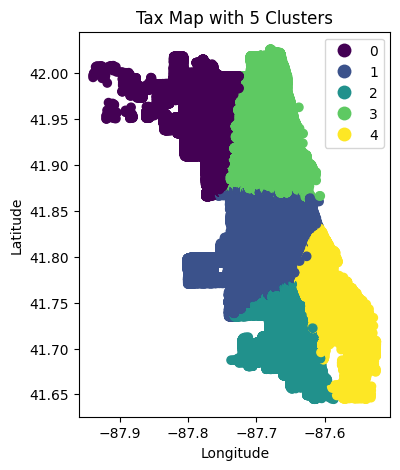

In [18]:
# Implement K-means clustering
# Here I'm using the skitlearn documentation website to write a simple K-means cluster.
kmeans = KMeans(n_clusters=5, random_state=42) #if you figured out what random_state does, try to remove it, to see what happens.
chicago_gdf['kmeans_cluster'] = kmeans.fit_predict(gdf_reproj[["longitude", "latitude"]])

# Visualize K-means clustering result
chicago_gdf.plot(column='kmeans_cluster', categorical=True, legend=True, figsize=(5,5), cmap='viridis')

plt.title('Tax Map with 5 Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


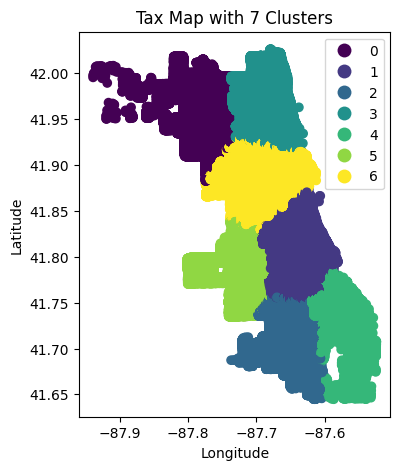

In [19]:
# Implement K-means clustering
# Here I'm using the skitlearn documentation website to write a simple K-means cluster.
kmeans = KMeans(n_clusters=7, random_state=42) #if you figured out what random_state does, try to remove it, to see what happens.
chicago_gdf['kmeans_cluster'] = kmeans.fit_predict(gdf_reproj[["longitude", "latitude"]])

# Visualize K-means clustering result
chicago_gdf.plot(column='kmeans_cluster', categorical=True, legend=True, figsize=(5,5), cmap='viridis')

plt.title('Tax Map with 7 Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



### T7: Evaluate the clustering results and choose an “optimal” value for n_clusters. Justify your choice in a markdown cell

In [20]:
chicago_gdf.describe()

,POLY_ID,ID,AREA,PIN_OLD,PIN,latitude,longitude,kmeans_cluster
count,592521.000000,592521.000000,592521.000000,5.925210e+05,5.925210e+05,592521.000000,592521.000000,592521.000000
mean,296261.000000,296547.003929,0.000060,1.013798e+09,9.918984e+08,41.842332,-87.687289,2.977989
std,171046.223762,171071.776698,0.001704,1.426036e+09,1.448937e+09,0.098881,0.065468,2.107325
min,1.000000,1.000000,0.000000,-2.147484e+09,-2.147484e+09,41.644691,-87.939095,0.000000
25%,148131.000000,148426.000000,0.000000,1.306111e+09,1.305426e+09,41.757614,-87.730307,1.000000
50%,296261.000000,296556.000000,0.000000,1.433316e+09,1.433303e+09,41.840014,-87.685876,3.000000
75%,444391.000000,444690.000000,0.000000,1.914209e+09,1.914209e+09,41.932674,-87.644585,5.000000
max,592521.000000,592849.000000,0.370000,2.132213e+09,2.132214e+09,42.026348,-87.524540,6.000000


Upon investigating both the various cluster maps and the source material I can conclude that the optimal value for n_clusters = 7
This dataset is composed of tax parcel polygons for property tax assessment for Cook County, IL. Based on inference, the dataset and map would be used by county employees to subdivide property tax assessment areas. Cook County is large and has high population density. Therefore, employees would need to break down the county into more manageable parcels to conduct property tax assessments on. For clarity of interpretation, 7 classes is best because it does not overwhelm the viewer but still shows the difference in the parcel groups.

### T8: DBSCAN Clustering: Implement the DBSCAN method. Experiment with different values of eps and min_samples in DBSCAN ( at least three)

### T9: Plot the clustering results for each combination of parameters. Therefore, you should create a plot matrix 3*3 ( min_samples and eps)

In [ ]:
# Parameter 1
# Code for DBSCAN eps=0.5 and min_samples=5
dbscan = DBSCAN(eps=0.5, min_samples=5)
chicago_gdf['dbscan_cluster'] = dbscan.fit_predict(chicago_gdf[["longitude", "latitude"]])

In [ ]:
# Parameter Plot 1
chicago_gdf.plot(column='dbscan_cluster', categorical=True, legend=True, figsize=(8, 8), cmap='Set1')
plt.title('DBSCAN Cluster Result - parameters 0.5x5')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [ ]:
# Parameter 2
# Code for DBSCAN eps=5 and min_samples=5
dbscan = DBSCAN(eps=5, min_samples=5)
chicago_gdf['dbscan_cluster'] = dbscan.fit_predict(chicago_gdf[["longitude", "latitude"]])

In [ ]:
# Parameter Plot 2
chicago_gdf.plot(column='dbscan_cluster', categorical=True, legend=True, figsize=(8, 8), cmap='Set1')
plt.title('DBSCAN Cluster Result - parameters 5x5')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [ ]:
# Parameter 3
# Code for DBSCAN eps=5 and min_samples=10
dbscan = DBSCAN(eps=5, min_samples=10)
chicago_gdf['dbscan_cluster'] = dbscan.fit_predict(chicago_gdf[["longitude", "latitude"]])

In [ ]:
# Parameter Plot 3
chicago_gdf.plot(column='dbscan_cluster', categorical=True, legend=True, figsize=(8, 8), cmap='Set1')
plt.title('DBSCAN Cluster Result - parameters 5x10')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

### T10: Using a text cell write your insights about the impact of modifying the eps and min_samples parameters, and finally recommend suitable values for eps and min_samples based on your analysis. Note: Consider the real-world implications of your findings, especially in the context of urban planning or data-driven decision-making.

First, it is necessary to define both the function and significance of both eps and min_samples. Eps (epsilon) is the maximum radius between two samples for them to be considered in the same neighborhood. Min_sample refers to the minimum number of samples required to form a cluster. Originally, I set the parameters to eps=0.5 and min_samples=5 which means that the max distance between samples in the same neighborhood was 0.5. However, with the eps set to 0.5, there is less definition in the plot. Alternatively, eps=5 and min_samples=5 clears up the data. The third and final set of parameters didn't necessarily change the depiction of the dataset. Therefore, I determined eps=5 and min_sample=5 as the most advantageous depiction of the Chicago property tax assessment areas. The higher the eps value, the more suitable for larger neighborhoods, counties, or parcels of land. The smaller the eps value, the more specific trends can be visualized in smaller communities.

Platforms and libraries like DBSCAN are essential to data-driven decision-making because it visualizes spatial data and provides evidence for future decisions in urban planning. DBSCAN can be an advantageous tool for urban planning because it condenses, clarifies, and interprets large datasets that would be very challenging to parse through manually and identify trends either in the data or the spatial dynamics.
